In [3]:
OPT_WEIGHTS_DATASET_PATH = "/content/drive/MyDrive/opt_weights"
OPT_WEIGHTS_MODEL_PATH = "/content/drive/MyDrive/opt_weights_model.pth"

In [4]:
import torch
import base64
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from PIL import Image
from datasets import load_dataset, Dataset, concatenate_datasets
from torchvision import transforms
from transformers import ViTModel, ViTConfig
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [5]:
MODEL_CHECKPOINT = 'google/vit-base-patch16-224-in21k'
IMAGE_DIMENSION = (224,224)
NUM_LABELS = 3

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(IMAGE_DIMENSION, antialias = True),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
        ])

In [6]:
class ViT(nn.Module):

  def __init__(self, config = ViTConfig(), num_labels = NUM_LABELS, model_checkpoint = MODEL_CHECKPOINT):
        super(ViT, self).__init__()
        self.vit = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer = False)
        self.classifier = (nn.Linear(config.hidden_size, num_labels))

  def forward(self, x):
    x = self.vit(x)['last_hidden_state']
    output = self.classifier(x[:, 0, :])
    return output

In [7]:
class ImageDataset(torch.utils.data.Dataset):

  def __init__(self, input_data):
      self.input_data = input_data
      self.transform = transform

  def __len__(self):
      return len(self.input_data)

  def get_images(self, idx):
      return self.transform(self.input_data[idx]['image'])

  def get_labels(self, idx):
      return self.input_data[idx]['label']

  def __getitem__(self, idx):
      train_images = self.get_images(idx)
      train_labels = self.get_labels(idx)
      return train_images, train_labels

In [8]:
# Convert images in dataset to RGB
def transforms(examples):
    examples["image"] = [image.convert("RGB") for image in examples["image"]]

    return examples

In [9]:
def create_model() -> nn.Module:
    # For pie chart
    def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))

            return '{:.1f}%\n({v:d})'.format(pct, v = val)

        return my_format

    # Load dataset
    dataset = load_dataset("imagefolder", data_dir = OPT_WEIGHTS_DATASET_PATH).map(transforms, batched = True)

    # Apply data augmentation to training set
    flipped_set = dataset["train"].map(
        lambda x: {"image" : x["image"].transpose(method = Image.FLIP_TOP_BOTTOM), "label" : x["label"]}
    )

    training_set = concatenate_datasets([dataset["train"], flipped_set])
    testing_set = dataset["test"]

    # Create a mapping for labels
    labels = training_set.features["label"].names
    label2id, id2label = dict(), dict()
    for i, label in enumerate(labels):
        label2id[label] = i
        id2label[i] = label

    # Visualize data in training and test sets
    fig, (ax1, ax2) = plt.subplots(1,2)

    train_dist = pd.Series(training_set["label"]).map(lambda x : id2label[x]).value_counts()
    ax1.pie(train_dist, labels = train_dist.index, autopct = autopct_format(train_dist))
    ax1.title.set_text("Distribution of data \n in training set")

    test_dist = pd.Series(testing_set["label"]).map(lambda x : id2label[x]).value_counts()
    ax2.pie(test_dist, labels = test_dist.index, autopct = autopct_format(test_dist))
    ax2.title.set_text("Distribution of data \n in testing set")

    # Set hyperparameters
    EPOCHS = 10
    LEARNING_RATE = 0.000152
    BATCH_SIZE = 32

    # START TRAINING MODEL
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ViT().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr = LEARNING_RATE)

    # Load training images
    train_dataset = ImageDataset(training_set)
    train_dataloader = DataLoader(train_dataset, num_workers = 1, batch_size = BATCH_SIZE, shuffle = True)

    # Fine tuning loop
    for i in range(EPOCHS):
        total_acc_train = 0
        total_loss_train = 0.0

        for train_image, train_label in tqdm(train_dataloader):
            output = model(train_image.to(device))
            loss = criterion(output, train_label.to(device))
            acc = (output.argmax(dim=1) == train_label.to(device)).sum().item()
            total_acc_train += acc
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f'Epochs: {i + 1} | Loss: {total_loss_train / len(train_dataset): .3f} | Accuracy: {total_acc_train / len(train_dataset): .3f}')

    # END TRAINING MODEL

    # START TESTING MODEL
    # Load testing images
    test_dataset = ImageDataset(testing_set)
    test_dataloader = DataLoader(test_dataset, num_workers = 1, batch_size = BATCH_SIZE, shuffle = False)

    y_true = []
    y_pred = []
    correct = 0
    total = 0

    # Testing loop
    for images, labels in tqdm(test_dataloader):
        output = model(images.to(device))
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum()
        y_true += labels.tolist()
        y_pred += predicted.tolist()

    # Display the confusion matrix
    cm = confusion_matrix(np.array(y_true), np.array(y_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = testing_set.features["label"].names)
    disp.plot()
    plt.show()

    # Display classification report
    report = classification_report(y_true, y_pred)
    print("Classification Report:\n", report)

    # END TESTING MODEL

    return model

In [10]:
def save_model(model : nn.Module):
    torch.save(model.state_dict(), OPT_WEIGHTS_MODEL_PATH)

In [11]:
def eval_model(model_path : str, test_dir : str):
    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ViT().to(device)
    model.load_state_dict(torch.load(model_path, map_location = device))
    model.eval()

    # Load dataset
    BATCH_SIZE = 32
    dataset = load_dataset("imagefolder", data_dir = test_dir).map(transforms, batched = True)

    # Load testing images
    testing_set = dataset["test"]
    test_dataset = ImageDataset(testing_set)
    test_dataloader = DataLoader(test_dataset, num_workers = 1, batch_size = BATCH_SIZE, shuffle = False)

    y_true = []
    y_pred = []
    correct = 0
    total = 0

    # Testing loop
    for images, labels in tqdm(test_dataloader):
        output = model(images.to(device))
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum()
        y_true += labels.tolist()
        y_pred += predicted.tolist()

    # Display the confusion matrix
    cm = confusion_matrix(np.array(y_true), np.array(y_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = testing_set.features["label"].names)
    disp.plot()
    plt.show()

    # Display classification report
    report = classification_report(y_true, y_pred)
    print("Classification Report:\n", report)

Resolving data files:   0%|          | 0/279 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/120 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/279 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map:   0%|          | 0/279 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 18/18 [00:17<00:00,  1.05it/s]


Epochs: 1 | Loss:  0.028 | Accuracy:  0.609


100%|██████████| 18/18 [00:16<00:00,  1.12it/s]


Epochs: 2 | Loss:  0.013 | Accuracy:  0.880


100%|██████████| 18/18 [00:16<00:00,  1.11it/s]


Epochs: 3 | Loss:  0.006 | Accuracy:  0.946


100%|██████████| 18/18 [00:16<00:00,  1.08it/s]


Epochs: 4 | Loss:  0.005 | Accuracy:  0.962


100%|██████████| 18/18 [00:16<00:00,  1.06it/s]


Epochs: 5 | Loss:  0.005 | Accuracy:  0.952


100%|██████████| 18/18 [00:17<00:00,  1.04it/s]


Epochs: 6 | Loss:  0.004 | Accuracy:  0.962


100%|██████████| 18/18 [00:17<00:00,  1.02it/s]


Epochs: 7 | Loss:  0.005 | Accuracy:  0.955


100%|██████████| 18/18 [00:18<00:00,  1.01s/it]


Epochs: 8 | Loss:  0.002 | Accuracy:  0.989


100%|██████████| 18/18 [00:18<00:00,  1.01s/it]


Epochs: 9 | Loss:  0.001 | Accuracy:  0.996


100%|██████████| 18/18 [00:18<00:00,  1.01s/it]


Epochs: 10 | Loss:  0.001 | Accuracy:  1.000


100%|██████████| 4/4 [00:01<00:00,  2.38it/s]


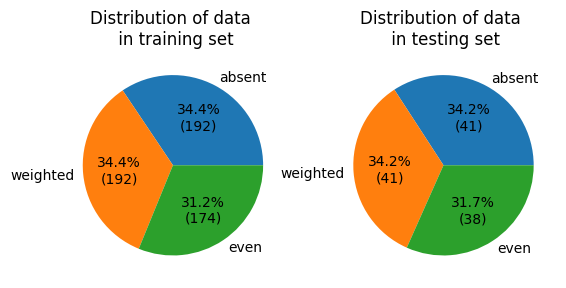

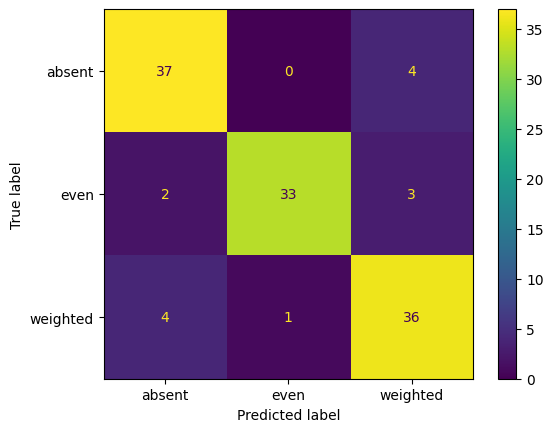

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88        41
           1       0.97      0.87      0.92        38
           2       0.84      0.88      0.86        41

    accuracy                           0.88       120
   macro avg       0.89      0.88      0.88       120
weighted avg       0.89      0.88      0.88       120



In [12]:
model = create_model()

In [13]:
save_model(model)

In [ ]:
# model_path = OPT_WEIGHTS_MODEL_PATH
# test_dir = OPT_WEIGHTS_DATASET_PATH
# eval_model(model_path, test_dir)